In [87]:
import pandas as pd 
import numpy as np
import glob
import os
import math
import scipy.stats as stats
from scipy.stats import pearsonr
from sklearn.decomposition import FactorAnalysis
import pingouin as pg
import semopy
import statsmodels.api as sm
from sklearn import linear_model
from mlxtend.feature_selection import SequentialFeatureSelector
from statsmodels.multivariate.manova import MANOVA
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from statsmodels.formula.api import ols
from scipy.stats import f_oneway, kruskal


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [56]:
# Read CSV
tam_df = pd.read_csv('/home/wb1115/VSCode_projects/cdss/cdss_1/cdss_1/tam_results/tam.csv')
demographics = pd.read_csv('/home/wb1115/VSCode_projects/cdss/cdss_1/cdss_1/demographic_results/demographics_processed.csv')

In [57]:
# Merge
tam_df = pd.merge(tam_df, demographics[['user_id', 'user_archetype', 'age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']])
# Move columns 
col = tam_df.pop('q28')
tam_df.insert(23, col.name, col)
col = tam_df.pop('q29')
tam_df.insert(24, col.name, col)
# Update column names
tam_df.columns = ['user_id',
 'user_archetype',
 'ai_attitude',
 'PU1',
 'PU2',
 'PU3',
 'PU4',
 'PU5',
 'PU6',
 'PU7',
 'PU8',
 'PEOU1',
 'PU9',
 'PEOU2',
 'SE1',
 'SE2',
 'voluntary',
 'SN1',
 'SN2',
 'prestige_image',
 'PU10',
 'PU11',
 'BC1',
 'BC2',
 'BC3',
 'clinical_workflow',
 'infrastructure',
 'intention',
 'colleagues',
 'PU12',
 'final_comments',
 'age',
 'sex_new',
 'medical_speciality_new',
 'grade_new',
 'ai_familiarity_new']

# Get result columns 
tam_df_results = tam_df.iloc[:,2:30]

In [58]:
# PU
pu_df = tam_df_results.filter(regex='PU')

In [9]:
# Mean and std
pu_df.mean().mean()
pu_df.std().mean()

3.529569892473118

0.8717235557707815

In [59]:
# Corrected item-total correlation
item_total_corr = pu_df.apply(lambda x: x.corr(pu_df.drop(columns=x.name).sum(axis=1)))
print(f"Item-Total Correlations for pu_df:\n", item_total_corr)

Item-Total Correlations for pu_df:
 PU1     0.582786
PU2     0.403667
PU3     0.616049
PU4     0.323770
PU5     0.697578
PU6     0.641762
PU7     0.800793
PU8     0.649634
PU9     0.451745
PU10    0.480605
PU11    0.444927
PU12    0.752123
dtype: float64


In [60]:
# Calculate bivariate correlations between all question pairs
correlation_matrix = pu_df.corr(method='spearman')  # Spearman for ordinal data

# Print correlation matrix (optional) - explore using heatmaps for better visualization
print("Bivariate Correlations (Spearman's rank):")
print(correlation_matrix)

Bivariate Correlations (Spearman's rank):
           PU1       PU2       PU3       PU4       PU5       PU6       PU7  \
PU1   1.000000  0.125745  0.393768  0.281075  0.559224  0.457258  0.478879   
PU2   0.125745  1.000000  0.459092  0.038105  0.153458  0.275379  0.442264   
PU3   0.393768  0.459092  1.000000  0.348442  0.609092  0.627293  0.655718   
PU4   0.281075  0.038105  0.348442  1.000000  0.364175  0.267302  0.294930   
PU5   0.559224  0.153458  0.609092  0.364175  1.000000  0.588774  0.622430   
PU6   0.457258  0.275379  0.627293  0.267302  0.588774  1.000000  0.773989   
PU7   0.478879  0.442264  0.655718  0.294930  0.622430  0.773989  1.000000   
PU8   0.149005  0.542004  0.375326  0.382090  0.471121  0.347549  0.563312   
PU9   0.304011  0.225226  0.062853  0.086529  0.221445  0.379682  0.585908   
PU10  0.400805  0.219249  0.102158  0.162767  0.384495  0.150177  0.296157   
PU11  0.532998  0.217506  0.230692  0.239100  0.322903  0.248848  0.397457   
PU12  0.670345  0.2855

In [99]:
# Create df for demographic analysis
combined_pu_df = pd.DataFrame(pu_df.mean(axis=1), columns=['pu_mean']).join(demographics[['user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']])

# Imputation with Mode for categorical columns
combined_pu_df['age_new'].fillna(combined_pu_df['age_new'].mode()[0], inplace=True)
combined_pu_df['sex_new'].fillna(combined_pu_df['sex_new'].mode()[0], inplace=True)
combined_pu_df['medical_speciality_new'].fillna(combined_pu_df['medical_speciality_new'].mode()[0], inplace=True)
combined_pu_df['grade_new'].fillna(combined_pu_df['grade_new'].mode()[0], inplace=True)
combined_pu_df['ai_familiarity_new'].fillna(combined_pu_df['ai_familiarity_new'].mode()[0], inplace=True)

# Test for normality
model = smf.ols("pu_mean ~ user_archetype + age_new + sex_new + medical_speciality_new + grade_new + ai_familiarity_new", data=combined_pu_df).fit()
shapiro_stat, shapiro_p_value = stats.shapiro(model.resid)
print(f"Shapiro test: W-statistic={shapiro_stat}, p-value={shapiro_p_value}")
stats.normaltest(model.resid)
stats.kstest(model.resid, 'norm')

# Test for vairance
# Levene's Test for user_archetype
levene_archetype_stat, levene_archetype_p_value = stats.levene(combined_pu_df['pu_mean'][combined_pu_df['user_archetype'] == 'a'],
                       combined_pu_df['pu_mean'][combined_pu_df['user_archetype'] == 'b'])
print(f"Levene's test for user_archetype: W-statistic={levene_archetype_stat}, p-value={levene_archetype_p_value}")
# Levene's Test for age_new
unique_ages = combined_pu_df['age_new'].unique()
grouped_ages = [combined_pu_df['pu_mean'][combined_pu_df['age_new'] == age] for age in unique_ages]
levene_age_stat, levene_age_p_value = stats.levene(*grouped_ages)
print(f"Levene's test for age_new: W-statistic={levene_age_stat}, p-value={levene_age_p_value}")
# Levene's Test for sex_new
levene_sex_stat, levene_sex_p_value = stats.levene(combined_pu_df['pu_mean'][combined_pu_df['sex_new'] == 'Male'],
                       combined_pu_df['pu_mean'][combined_pu_df['sex_new'] == 'Female'])
print(f"Levene's test for sex_new: W-statistic={levene_sex_stat}, p-value={levene_sex_p_value}")
# Levene's Test for medical_speciality_new
unique_medical_specialities = combined_pu_df['medical_speciality_new'].unique()
grouped_medical_specialities = [combined_pu_df['pu_mean'][combined_pu_df['medical_speciality_new'] == speciality] for speciality in unique_medical_specialities]
levene_speciality_stat, levene_speciality_p_value = stats.levene(*grouped_medical_specialities)
print(f"Levene's test for medical_speciality_new: W-statistic={levene_speciality_stat}, p-value={levene_speciality_p_value}")
# Levene's Test for grade_new
unique_grades = combined_pu_df['grade_new'].unique()
grouped_grades = [combined_pu_df['pu_mean'][combined_pu_df['grade_new'] == grade] for grade in unique_grades]
levene_grade_stat, levene_grade_p_value = stats.levene(*grouped_grades)
print(f"Levene's test for grade_new: W-statistic={levene_grade_stat}, p-value={levene_grade_p_value}")
# Levene's Test for ai_familiarity_new
unique_ais = combined_pu_df['ai_familiarity_new'].unique()
grouped_ais = [combined_pu_df['pu_mean'][combined_pu_df['ai_familiarity_new'] == ai] for ai in unique_ais]
levene_ai_stat, levene_ai_p_value = stats.levene(*grouped_ais)
print(f"Levene's test for ai_familiarity_new: W-statistic={levene_ai_stat}, p-value={levene_ai_p_value}")

if shapiro_p_value >= 0.05 and levene_archetype_p_value >=0.05 and levene_age_p_value >=0.05 and levene_sex_p_value >= 0.05 and levene_speciality_p_value >=0.05 and levene_grade_p_value >= 0.05 and levene_ai_p_value >= 0.05:
    anova_bool = True
else:
    anova_bool = False

print('\n')
print('anova_bool:', anova_bool)
print('\n')

# Perform the appropriate test
# Do anover independantly for each variable and collectivly 
if anova_bool:
    print('Collective')
    model = ols("pu_mean ~ user_archetype + age_new + sex_new + medical_speciality_new + grade_new + ai_familiarity_new", data=combined_pu_df).fit()
    aov_table = sm.stats.anova_lm(model, typ=2)
    # Interpretation
    for index, row in aov_table.iterrows():
        sum_sq, df_value, f_value, pr_f = row
        print(f"ANOVA for {index}: Statistic={f_value:.4f}, p-value={pr_f:.4f}")
        if pr_f < 0.05:
            print(f"  -> The differences in {index} are statistically significant.\n")
        else:
            print(f"  -> The differences in {index} are not statistically significant.\n")

# Function to perform ANOVA
def perform_anova(df, group_var):
    groups = df.groupby(group_var)['pu_mean'].apply(list)
    stat, p_value = f_oneway(*groups)
    return stat, p_value

# Function to perform Kruskal-Wallis H test
def perform_kruskal(df, group_var):
    groups = df.groupby(group_var)['pu_mean'].apply(list)
    stat, p_value = kruskal(*groups)
    return stat, p_value

print('\nIndependant')
independent_vars = ['user_archetype', 'age_new', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']
results = {}
for var in independent_vars:
    if anova_bool:
        stat, p_value = perform_anova(combined_pu_df, var)
        test_name = 'ANOVA'
    else:
        stat, p_value = perform_kruskal(combined_pu_df, var)
        test_name = 'Kruskal-Wallis'
    results[var] = {'test': test_name, 'statistic': stat, 'p_value': p_value}

# Print the results
for var, result in results.items():
    print(f"{result['test']} for {var}: Statistic={result['statistic']:.4f}, p-value={result['p_value']:.4f}")
    if result['p_value'] < 0.05:
        print(f"  -> The differences in {var} are statistically significant.\n")
    else:
        print(f"  -> The differences in {var} are not statistically significant.\n")

Shapiro test: W-statistic=0.9665393829345703, p-value=0.42921146750450134


NormaltestResult(statistic=2.3921767821869846, pvalue=0.3023746731202391)

KstestResult(statistic=0.23351550444722868, pvalue=0.05711512696907728, statistic_location=0.5300701893095106, statistic_sign=1)

Levene's test for user_archetype: W-statistic=0.5420228241682179, p-value=0.4675095434408971
Levene's test for age_new: W-statistic=1.1102932759449615, p-value=0.3728607054234604
Levene's test for sex_new: W-statistic=0.2646853631476783, p-value=0.610818208763992
Levene's test for medical_speciality_new: W-statistic=0.1354114174645457, p-value=0.9380539789792061
Levene's test for grade_new: W-statistic=3.7352118993723984, p-value=0.0630960911551589
Levene's test for ai_familiarity_new: W-statistic=0.5424188205628387, p-value=0.6574004996227871


anova_bool: True


Collective
ANOVA for user_archetype: Statistic=0.0181, p-value=0.8946
  -> The differences in user_archetype are not statistically significant.

ANOVA for age_new: Statistic=0.5779, p-value=0.6826
  -> The differences in age_new are not statistically significant.

ANOVA for sex_new: Statistic=0.4728, p-value=0.5010
  -> The differences in sex_new are not statistically significant.

ANOVA for medical_speciality_new: Statistic=

Text(0.5, 1.0, 'Probability plot of regression residuals \n with R value')

<bound method Axes.set of <Axes: title={'center': 'Probability plot of regression residuals \n with R value'}, xlabel='Theoretical quantiles', ylabel='Ordered Values'>>

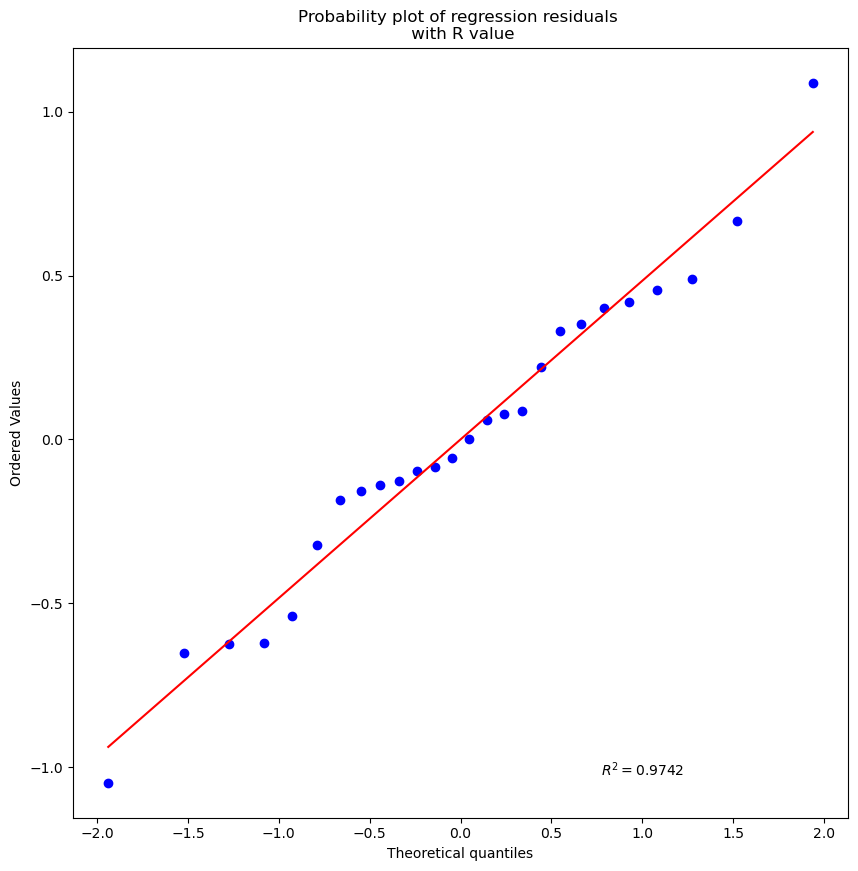

In [45]:
fig = plt.figure(figsize= (10, 10))
ax = fig.add_subplot(111)

normality_plot, stat = stats.probplot(model.resid, plot= plt, rvalue= True)
ax.set_title("Probability plot of regression residuals \n with R value")
ax.set

plt.show()

# Old

In [47]:
mardia_test = pg.multivariate_normality(pu_df, alpha=0.05)
print(mardia_test)

HZResults(hz=0.9957092836013285, pval=0.029661972701394965, normal=False)


In [37]:
pg.box_m(data=pu_df.join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]), dvs=['PU1', 'PU2', 'PU3', 'PU4', 'PU5', 'PU6', 'PU7', 'PU8', 'PU9', 'PU10', 'PU11', 'PU12'], group='age')
pg.box_m(data=pu_df.join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]), dvs=['PU1', 'PU2', 'PU3', 'PU4', 'PU5', 'PU6', 'PU7', 'PU8', 'PU9', 'PU10', 'PU11', 'PU12'], group='sex_new')
pg.box_m(data=pu_df.join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]), dvs=['PU1', 'PU2', 'PU3', 'PU4', 'PU5', 'PU6', 'PU7', 'PU8', 'PU9', 'PU10', 'PU11', 'PU12'], group='medical_speciality_new')
pg.box_m(data=pu_df.join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]), dvs=['PU1', 'PU2', 'PU3', 'PU4', 'PU5', 'PU6', 'PU7', 'PU8', 'PU9', 'PU10', 'PU11', 'PU12'], group='grade_new')
pg.box_m(data=pu_df.join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]), dvs=['PU1', 'PU2', 'PU3', 'PU4', 'PU5', 'PU6', 'PU7', 'PU8', 'PU9', 'PU10', 'PU11', 'PU12'], group='ai_familiarity_new')

/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/pandas/core/frame.py:10866: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/pingouin/multivariate.py:386: RuntimeWarning: divide by zero encountered in divide
  c *= (1 / v).sum() - 1 / v.sum()


,Chi2,df,pval,equal_cov
box,NaN,1638.0,NaN,False


,Chi2,df,pval,equal_cov
box,75.593733,78.0,0.556115,True


/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/pingouin/multivariate.py:375: RuntimeWarning: invalid value encountered in power
  M = ((np.linalg.det(covs) / S_det) ** (v / 2)).prod()


,Chi2,df,pval,equal_cov
box,NaN,234.0,NaN,False


/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/pingouin/multivariate.py:375: RuntimeWarning: invalid value encountered in power
  M = ((np.linalg.det(covs) / S_det) ** (v / 2)).prod()


,Chi2,df,pval,equal_cov
box,NaN,78.0,NaN,False


/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/pandas/core/frame.py:10866: RuntimeWarning: Degrees of freedom <= 0 for slice
  base_cov = np.cov(mat.T, ddof=ddof)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/numpy/linalg/linalg.py:2180: RuntimeWarning: invalid value encountered in det
  r = _umath_linalg.det(a, signature=signature)
/home/wb1115/anaconda3/envs/cdss/lib/python3.10/site-packages/pingouin/multivariate.py:386: RuntimeWarning: divide by zero encountered in divide
  c *= (1 / v).sum() - 1 / v.sum()


,Chi2,df,pval,equal_cov
box,NaN,234.0,NaN,False


In [27]:
formula

'PU1+PU2+PU3+PU4+PU5+PU6+PU7+PU8+PU9+PU10+PU11+PU12 ~ age + sex_new + medical_speciality_new + grade_new + ai_familiarity_new'

In [26]:
# Prepare the formula for MANOVA
# Include all questionnaire items in the dependent variables section
dependent_vars = '+'.join([f'{i}' for i in pu_df.columns])
formula = f'{dependent_vars} ~ age + sex_new + medical_speciality_new + grade_new + ai_familiarity_new'

manova = MANOVA.from_formula(formula, data=pu_df.join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]))
result = manova.mv_test()

In [29]:
print(result)


                  Multivariate linear model
                                                              
--------------------------------------------------------------
         Intercept        Value   Num DF Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.1534 12.0000 5.0000  2.2992 0.1841
           Pillai's trace 0.8466 12.0000 5.0000  2.2992 0.1841
   Hotelling-Lawley trace 5.5182 12.0000 5.0000  2.2992 0.1841
      Roy's greatest root 5.5182 12.0000 5.0000  2.2992 0.1841
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
          sex_new         Value   Num DF Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.2781 12.0000 5.0000  1.0816 0.5018
           Pillai's trace 0.7219 12.0000 5.0000  1.0816 0.5018
   Hotellin

In [38]:
# Prepare the formula for MANOVA
# Include all questionnaire items in the dependent variables section
dependent_vars = '+'.join([f'{i}' for i in pu_df.columns])
formula = f'{dependent_vars} ~ age + sex_new + medical_speciality_new + grade_new + ai_familiarity_new'

manova = MANOVA.from_formula(formula, data=pu_df.rank().join(demographics[['age', 'sex_new', 'medical_speciality_new', 'grade_new', 'ai_familiarity_new']]))
result = manova.mv_test()

In [39]:
print(result)

                  Multivariate linear model
                                                              
--------------------------------------------------------------
         Intercept        Value   Num DF Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.2193 12.0000 5.0000  1.4837 0.3489
           Pillai's trace 0.7807 12.0000 5.0000  1.4837 0.3489
   Hotelling-Lawley trace 3.5609 12.0000 5.0000  1.4837 0.3489
      Roy's greatest root 3.5609 12.0000 5.0000  1.4837 0.3489
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
          sex_new         Value   Num DF Den DF F Value Pr > F
--------------------------------------------------------------
            Wilks' lambda 0.4661 12.0000 5.0000  0.4774 0.8635
           Pillai's trace 0.5339 12.0000 5.0000  0.4774 0.8635
   Hotellin